# Dealing with real data

In the previous part of the tutorial


TODO

## Capacitance artefacts

If we stop looking at the flat (constant voltage) bit, and view the whole signal instead, one of the first things we might notice are the spikes that occur at each transition.

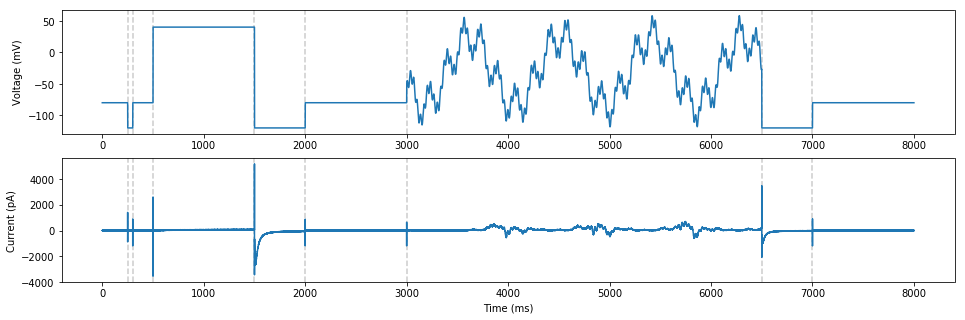

In [130]:
import matplotlib.pyplot as plt
import myokit
import numpy as np
import pints
import scipy.stats

# Load Cell 1 from Beattie et al.
log = myokit.DataLog.load('resources/sine-wave-data/cell-1.zip').npview()

# Create a figure
fig = plt.figure(figsize=(16, 5))

ax1 = fig.add_subplot(2, 1, 1)
ax1.set_ylabel('Voltage (mV)')

ax2 = fig.add_subplot(2, 1, 2)
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Current (pA)')

# Highlight the transitions:
for t in [250, 300, 500, 1500, 2000, 3000, 6500, 7000]:
    ax1.axvline(t + .1, ls='--', color='#cccccc')
    ax2.axvline(t + .1, ls='--', color='#cccccc')

ax1.plot(log.time(), log['voltage'])  # Convert from nA to pA
ax2.plot(log.time(), log['current'] * 1000)  # Convert from nA to pA
    
plt.show()

These are the remnants of capacitative charging currents that occur during the experiment, after on-line filtering by the experimenter.
They arise through a combination of "pipette capacitance" (the pipette wall and other parts of the equipment store a small, voltage-dependent amount of charge), "membrane capacitance"


### Modelling pipette capacitance

How do these artefacts arise?

In manual patch-clamp, the submerged part of the pipette acts like a [capacitor](https://en.wikipedia.org/wiki/Capacitor) between the pipette and bath solutions.
Whenever a change in voltage is applied, the amount of charge stored in the pipette wall changes, and the current "used" or "released" by this charging or uncharging is superimposed on the current of interest.
In the diagram below (adapted from [Lei et al., 2020](https://doi.org/10.1098/rsta.2019.0348)) this is shown as a capacitor between the internal and bath electrode, labelled "pipette capacitance", "stray capacitance", or "parasitic capacitance".
(Similar effects occur in automated patch-clamp, so that "parasitic" or "stray" are perhaps the more general terms.)

The current charging or uncharging of the pipette can be modelled as

\begin{equation}
I_p(t) = C_p \dot{V_p}(t)
\end{equation}

where $C_p$ is the pipette (or parasitic) capacitance, and $\dot{V_p}(t)$ is the _rate of change of the pipette voltage_.
If the pipette voltage followed our intended voltage protocol exactly, we would have $V_p = V_\text{command}$, so that the $V_p(t)$ would be infinite at the step transitions, and zero during constant-voltage steps.
But that's not what happens in real life!
So to model the pipette capacitance, we need to take into account the time it takes for the amplifier to set $V_p$ to the desired potential:

\begin{equation}
\dot{V_p}(t) = \frac{V_\text{command} - V_p}{\tau_\text{clamp}}
\end{equation}

Typical values for the above equations are $C_p = 5\text{pF}$ and $\tau_\text{clamp} = 0.8 \mu\text{s}$ ([Weerakoon et al., 2009](https://doi.org/10.1109/TBCAS.2008.2005419)).
We can use these values to simulate the charging currents:

<img src="resources/patch-clamp-2-pipette-capacitance.png" width="598px" />

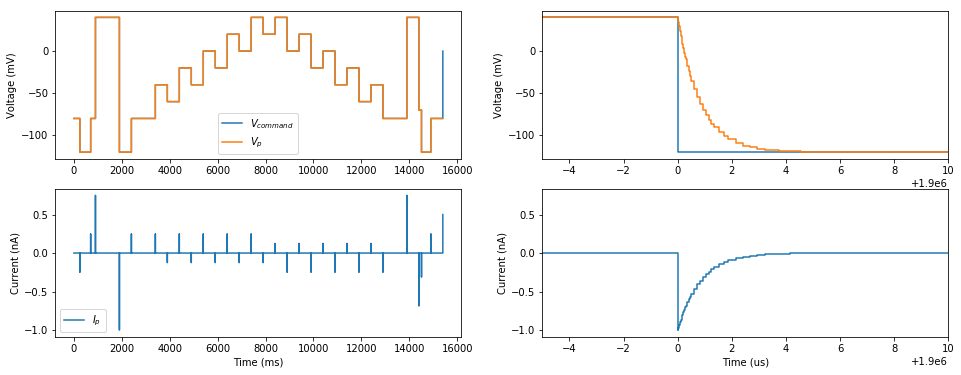

In [51]:
import myokit
import matplotlib.pyplot as plt

protocol = myokit.load_protocol('resources/simplified-staircase.mmt')
model = myokit.parse_model('''
[[model]]
clamp.Vp = -80

[engine]
time = 0 bind time
    in [ms]

[clamp]
Vc = 0 bind pace
    in [mV]
dot(Vp) = (Vc - Vp) / tau
    in [mV]
tau = 8e-4 [ms]
Cp = 5 [pF]

# Note that pF * (mV/ms) = pA
Ip = Cp * dot(Vp)
    in [pA]
''')

s = myokit.Simulation(model, protocol)
d = s.run(15400).npview()

fig = plt.figure(figsize=(16, 6))

# Zoom parameters
xmin, xmax = 1899.995, 1900.01

# Left
ax = plt.subplot(2, 2, 1)
ax.set_ylabel('Voltage (mV)')
ax.plot(d.time(), d['clamp.Vc'], label='$V_{command}$', drawstyle='steps-post')
ax.plot(d.time(), d['clamp.Vp'], label='$V_p$', drawstyle='steps-post')
ax.legend()

ax = plt.subplot(2, 2, 3)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Current (nA)')
ax.plot(d.time(), d['clamp.Ip'] * 1e-6, label='$I_p$', drawstyle='steps-post')
ax.legend()

# Right
ax = plt.subplot(2, 2, 2)
ax.set_ylabel('Voltage (mV)')
ax.plot(d.time() * 1e3, d['clamp.Vc'], label='$V_{command}$', drawstyle='steps-post')
ax.plot(d.time() * 1e3, d['clamp.Vp'], label='$V_p$', drawstyle='steps-post')
ax.set_xlim(xmin * 1e3, xmax * 1e3)

ax = plt.subplot(2, 2, 4)
ax.set_xlabel('Time (us)')
ax.set_ylabel('Current (nA)')
ax.plot(d.time() * 1e3, d['clamp.Ip'] * 1e-6, label='$I_p$', drawstyle='steps-post')
ax.set_xlim(xmin * 1e3, xmax * 1e3)

plt.show()

In the left panels, we can see the currents are very strong reaching into the $\text{nA}$ range in our simulation.
Because their time course is determined by the speed of the patch-clamp amplifier (which is luckily very fast), they are also very short.

### On-line pipette capacitance compensation

As in the simulation, real charging currents are _large_, typically in the $\text{nA}$ range (see [Sigworth 1995](https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q=sigworth+design+of+patch+clamp&btnG=)).
This large magnitude causes several problems.
Firstly, as the charging current often overshadows the current of interest, it will need to be filtered out or accounted for somehow.
But if the current is large enough, it can also "saturate" the [op-amp](https://en.wikipedia.org/wiki/Operational_amplifier) used to measure current (as well as other parts of the circuitry, see Sigworth 1995).
This saturation can lead to a complete loss of information (which no amount of post-processing can fix), which lasts for tens to hundreds of milliseconds.
During this time, this voltage-clamp circuitry can no longer function, so that control over the membrane potential is lost.

So it seems off-line correction is impossible in this case, and the charging current will need to be reduced/avoided (e.g. by coating the pipettes, see Sigworth 1995) or corrected on-line in a process known as "pipette capacitance compensation" (or "cancellation" or "neutralisation").
The goal of pipette capacitance compensation is to provide the current needed to charge the pipette from a secondary source, so that the charging current no longer passes through the measurement equipment.
If this current can be made to match the required charging current _exactly_, then a clean measurement can be made.

In manual patch clamp, this matching step is done by the experimenter, who adjusts the controls on the compensation circuitry until the charging currents have visibly been cancelled out.
This is done just before the cell membrane is ruptured, so that the matching is performed in the absense of any membrane currents.
To stop the circuitry from saturating, this is performed with the amplifier on a "low gain" setting, switching to the more sensitive high gain setting once compensation is in place.

Some patch clamp amplifiers contain more than one compensation circuit, allowing both a "fast" and a "slow" pipette capacitance current to be mixed in.


### Membrane capacitance compensation

Moving on from the pipette, the cell itself has a much bigger capacitance, and this also needs to be charged!



### Dealing with the remnants of imperfect capacitance correction

Unfortunately, this method has its limits.
For a start, matching the two currents exactly is difficult.
And even if the match is made well, conditions (e.g. the fluid level in the bath) may change in between calibration and measurement, so that errors creep in.


FAST & SLOW PIP CAP CORRECTION

SIMILAR FOR CM CORRECTION

INTERACTS IN NON-TRIVIAL WAYS WITH SERIES RESISTANCE COMPENSATION

CUT OUT A FEW POINTS




In [ ]:
TODODODODODODODTODODODODODODODTODODODODODODODTODODODODODODODTODODODODODODODTODODODODODODOD

additive: noise, leak, endogenous currents, estimating E, capacitative spikes


NEXT: DEALING WITH IT BY FILTERING / POST-PROCESSING / ONLINE-PROCESSING, OR BY ADDING TO NOISE MODEL AND FITTING (FINDING SIGMA)

THIS IS AN EXAMPLE OF WHAT WE DO LATER TOO!

In [3]:
import matplotlib.pyplot as plt
import myokit
import numpy as np
import pints

from library import ModelCVODESolver as Model

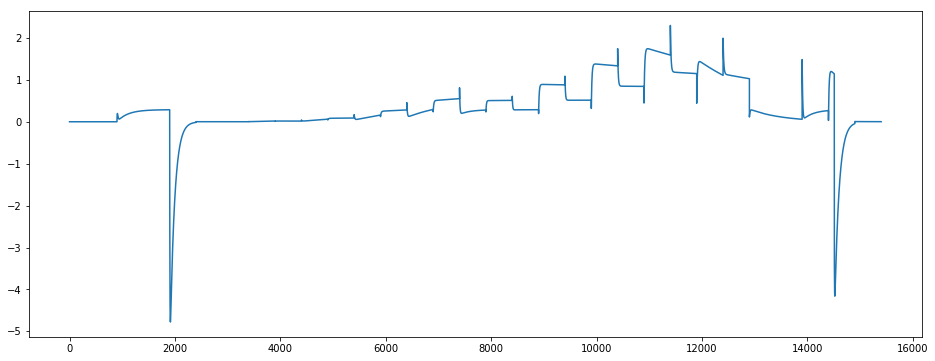

In [4]:
protocol = myokit.load_protocol('resources/simplified-staircase.mmt')
model1 = Model(protocol)

# Define a parameter vector
parameters = np.array([3e-4, 0.07, 3e-5, 0.05, 0.09, 9e-3, 5e-3, 0.03, 0.2])

# Evaluate the model
times = np.arange(0, 15400, 0.1)
values1 = model1.simulate(parameters, times)

plt.figure(figsize=(16, 6))
plt.plot(times, values1)
plt.show()

In [18]:
class ModelVoltageError(pints.ForwardModel):
    """A forward model that runs simulations with CVODE."""

    def __init__(self, protocol):

        # Load a model, and isolate the HH ion current model part
        model = myokit.load_model('resources/full2-voltage-clamp-ikr-linleak.mmt')
        parameters = ['ikr.p' + str(1 + i) for i in range(9)]

        # Create a CVODE Simulation
        self.sim = myokit.Simulation(model, protocol)

        # Set the -80mV steady state as the default state
        #self.sim.set_default_state(hh_model.steady_state(-80))

    def n_parameters(self):
        return 9

    def simulate(self, parameters, times):

        # Reset to default time and state
        self.sim.reset()

        # Apply parameters
        for i, p in enumerate(parameters):
            self.sim.set_constant('ikr.p' + str(1 + i), p)

        # Run
        tmax = times[-1] + (times[-1] - times[-2])
        try:
            log = self.sim.run(tmax, log_times=times, log=['voltageclamp.Iout'])
            return log['voltageclamp.Iout']
        except myokit.SimulationError:
            print('Error evaluating with parameters: ' + str(parameters))
            return np.nan * times


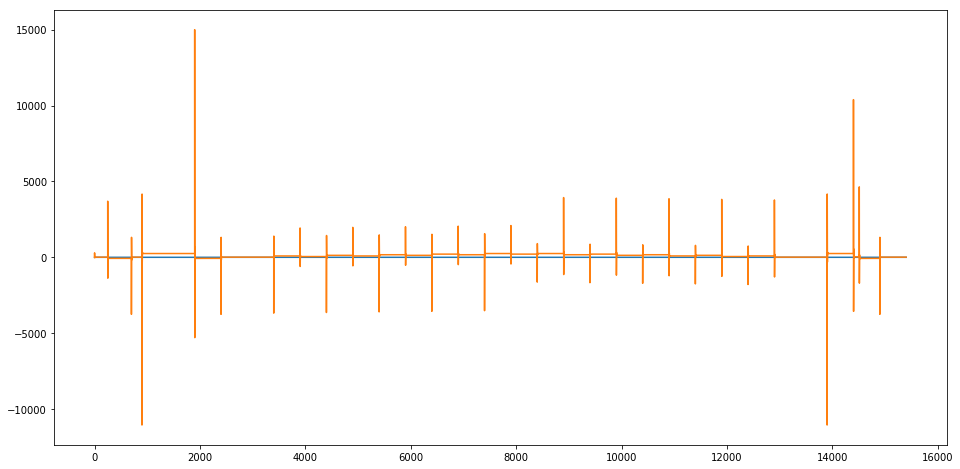

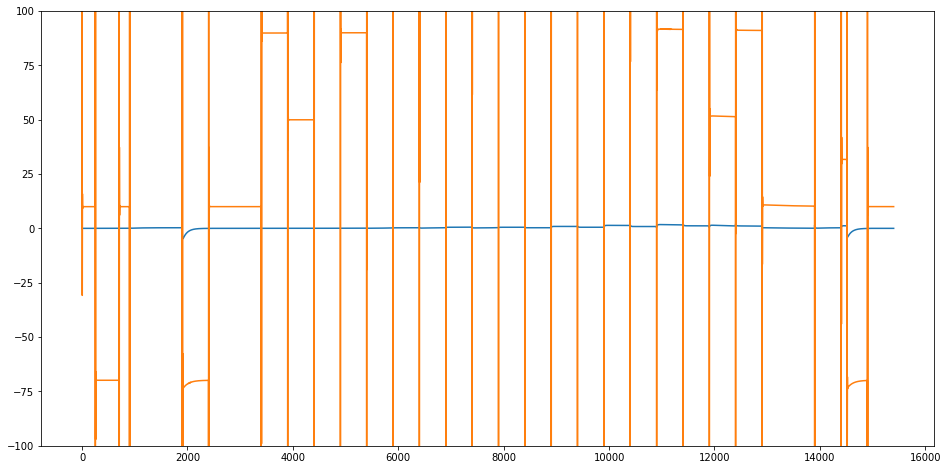

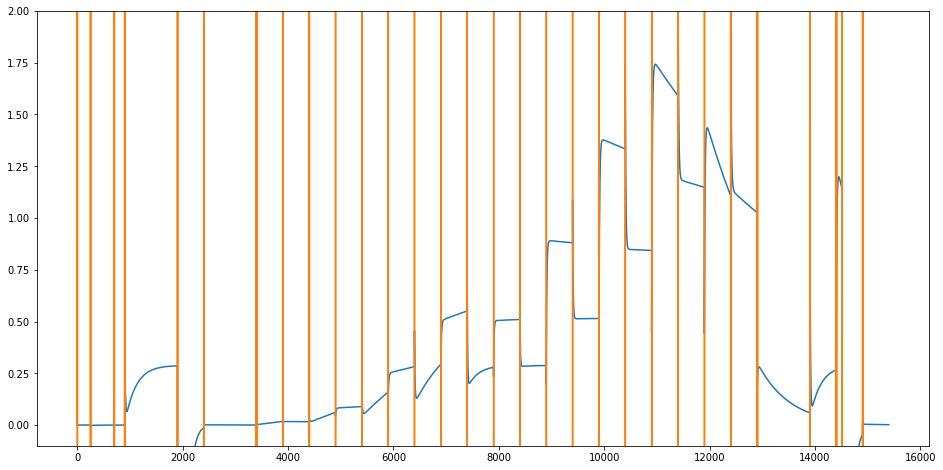

In [21]:
model2 = ModelVoltageError(protocol)

values2 = model2.simulate(parameters, times)

plt.figure(figsize=(16, 8))
plt.plot(times, values1)
plt.plot(times, values2)

plt.figure(figsize=(16, 8))
plt.plot(times, values1)
plt.plot(times, values2)
plt.ylim(-100, 100)
plt.show()

plt.figure(figsize=(16, 8))
plt.plot(times, values1)
plt.plot(times, values2)
plt.ylim(-0.1, 2)
plt.show()

## Capacitance filtering

Use a myokit.protocol to find the steps, cut a bit out

## Leak correction


We don't know best way


Explain use of ramps?

## Endogenous currents

(And maybe even gating current!)

Subtraction protocol!


## Reversal potential

Estimate from concentrations

Estimate from crossings? But hard if leaks aren't done right.
Use carefully placed ramps to avoid leak?

## Summary
